# Import of libraries

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy

# Dataset

In [2]:
def load_dataset():
    """
    Load the dataset contained in a .h5 file
    
    Returns:
    - train_set_x_orig (numpy.ndarray): Training set X
    - train_set_y_orig (numpy.ndarray): Training set Y
    - test_set_x_orig (numpy.ndarray): Test set X
    - test_set_y_orig (numpy.ndarray): Test set Y
    - classes (numpy.ndarray) = Classes set
    """
    
    train_dataset = h5py.File('dataset/train_happy.h5', 'r')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:])
    train_set_y_orig = np.array(train_dataset['train_set_y'][:])
    classes = np.array(train_dataset['list_classes'][:])
    
    test_dataset = h5py.File('dataset/test_happy.h5', 'r')
    test_set_x_orig = np.array(test_dataset['test_set_x'][:])
    test_set_y_orig = np.array(test_dataset['test_set_y'][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1,-1))
    test_set_y_orig = test_set_y_orig.reshape((1, -1))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [4]:
def dimensions():
    """
    Prints information related to the previously loaded dataset
    """
    
    num_examples_train = train_set_x_orig.shape[0]
    num_examples_test = test_set_x_orig.shape[0]
    width = train_set_x_orig.shape[1]
    heigh = train_set_x_orig.shape[2]
    num_classes = len(classes)
    
    print(f'Number of training examples : {num_examples_train}')
    print(f'Number of test examples: {num_examples_test}')
    print(f'Photo dimension: {width}x{heigh}')
    print(f'Shape training dataset X: {train_set_x_orig.shape}')
    print(f'Shape training dataset Y: {train_set_y.shape}')
    print(f'Shape test dataset X: {test_set_x_orig.shape}')
    print(f'Shape test dataset Y: {test_set_y.shape}')
    print(f'Number of classes: {num_classes}')

In [5]:
dimensions()

Number of training examples : 600
Number of test examples: 150
Photo dimension: 64x64
Shape training dataset X: (600, 64, 64, 3)
Shape training dataset Y: (1, 600)
Shape test dataset X: (150, 64, 64, 3)
Shape test dataset Y: (1, 150)
Number of classes: 2


The picture number 80 has the value: 1


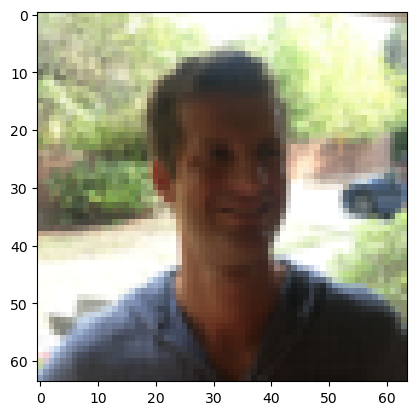

In [6]:
num = 80
plt.imshow(train_set_x_orig[num])
print(f"The picture number {num} has the value: {train_set_y[0, num]}")

# Algorithm (from 0)

We convert the images into vectors:
(px width, x height, 3) -> (px width * px height * 3, 1).

Each column in the dataset represents an image.

In [7]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print(f"train_set_x_flatten: {train_set_x_flatten.shape}")
print(f"test_set_x_flatten: {test_set_x_flatten.shape}")
print(f"train_set_y: {train_set_y.shape}")
print(f"test_set_y: {test_set_y.shape}")

train_set_x_flatten: (12288, 600)
test_set_x_flatten: (12288, 150)
train_set_y: (1, 600)
test_set_y: (1, 150)


We normalize the dataset to make the algorithm work faster

In [8]:
train_set_x = train_set_x_flatten /255.
test_set_x = test_set_x_flatten / 255.

## Functions

$sigmoid(z) = \frac{1}{1 + e^{-z}}$ where $z = w^T x + b $

In [9]:
def sigmoid(z):
    """
    Compute sigmoid function of z
    
    Args:
    - z: Scalar or numpy array
    
    Returns:
    - s: Sigmoid function of z
    """
    
    s = 1/(1+np.exp(-z))
    return s

The cost function uses will be:

$$J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$$

The goal is to minimize it. To do this, we must calculate the w and b that minimize the cost funcion. To find such variables, **gradient descent** will be used. The partial derivatives of J with respect to w and b are as follows:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [10]:
def forward_propagation(w, b, X, Y):
    """
    Returns the cost and partial derivatives of J with respect to w and b
    
    Args:
    - w (numpy.ndarray): Weights vector (num_px*num_px*3, 1)
    - b (int): Bias
    - X (numpy.ndarray): Data set (num_px*num_px*3, num_examples)
    - Y (numpy.ndarray): Results vector (1, num_examples) -> 0 if the face doesn't have a smile, 1 if it does
    
    Devuelve:
    - grads (dict): Dictionary with the partial derivative of J with respect to w ['dw'] and with respect to b ['db']
    - cost (float): Cost function value for function parameters
    """
    
    m = X.shape[1]  #Number of examples
    
    A = sigmoid(np.dot(w.T, X) + b)   #Result of sigmoid function
    cost = -1/m * np.sum(np.dot(Y,np.log(A).T) + np.dot((1-Y),np.log(1-A).T))
    dw = 1/m * np.dot(X, (A-Y).T)     #Partial derivative of J with respect to w
    db = 1/m * np.sum(A-Y)            #Partial derivative of J with respect to b
    
    grads = {"dw":dw, "db":db}
    
    return grads, cost

In [11]:
def gradient_descent (w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    Optimizes w and b through the gradient descent algorithm
    
    Args:
    - w (numpy.ndarray): Weights vector (num_px*num_px*3, 1)
    - b (int): Bias
    - X (numpy.ndarray): Data set (num_px*num_px*3, num_examples)
    - Y (numpy.ndarray): Results set (1, num_examples) -> 0 if the face doesn't have a smile, 1 if it does
    - num_iterations (int): Number of iterations of the optimization loop
    - learning_rate (float): Learning rate for updating weights and bias
    - print_cost (boolean):True to print the cost every 100 steps
    
    Returns:
    - params (dict): Dictionary with the final value of w ['w'] and b ['b']
    - costs (list): Costs list per 100 steps
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(1, num_iterations+1):
        grads, cost = forward_propagation(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        if i%100==0 or i==1:
            costs.append(cost)
            if print_cost:
                print(f"Cost in the iteration {i}: {cost}")
        
    params = {"w": w, "b":b}
    
    return params, costs

In [12]:
def predict(w, b, X):
    """
    Predict 0 or 1
    
    Args:
    - w (numpy.ndarray): Weights vector (num_px*num_px*3, 1)
    - b (int): Bias
    - X (numpy.ndarray): Data set (num_px*num_px*3, num_examples)
    
    Devuelve:
    - Y_prediction (numpy.ndarray): Vector with approximations 0 or 1 (1, num_examples)
    """
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        if(A[0,i]>0.5):
            Y_prediction[0,i] = 1
    
    return Y_prediction

In [13]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate=0.5, print_cost=False):
    '''
    Function that encompasses the entire logistic regression model
    
    Args:
    - X_train (numpy.ndarray): Training data set (num_px*num_px*3, num_examples)
    - Y_train (numpy.ndarray): Training results set  (1, num_examples) 
    - X_test (numpy.ndarray): Test data set (num_px*num_px*3, num_examples)
    - Y_test (numpy.ndarray): Test results set (1, num_examples) 
    - num_iterations (int): Number of iterations of the optimization loop
    - learning_rate (float): Learning rate for updating weights and bias
    - print_cost (boolean): True to print the cost per 100 steps and the accuracy of the model for training and testing
    
    Devuelve:
    - d (dict): Dictionary containing list of costs ["costs"], prediction in test examples ["Y_prediction_test"],
                 prediction in training examples ["Y_prediction_train"], accuracy in training ["score_train"],
                 accuracy in test ["score_test"], weight vector ["w"], bias ["b"]
    '''
    
    w = np.zeros((X_train.shape[0], 1))
    b = 0.
    
    params, costs = gradient_descent(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params['w']
    b = params['b']
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    score_train = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    score_test = 100 - np.mean(np.abs(Y_prediction_test - Y_test))* 100
    
    if print_cost:
        print(f'Accuracy in training: {score_train}%')
        print(f'Accuracy in test: {score_test}%')
        
    d = {"costs": costs,
         "Y_prediction_train" : Y_prediction_train,
         "Y_prediction_test": Y_prediction_test, 
         "score_train": score_train,
         "score_test": score_test,
         "w" : w, 
         "b" : b}
    
    return d

## Algorithm tests

In [14]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost in the iteration 1: 0.6931471805599453
Cost in the iteration 100: 2.016452672651478
Cost in the iteration 200: 0.9400012027717219
Cost in the iteration 300: 0.5109581003071446
Cost in the iteration 400: 0.21272586466206095
Cost in the iteration 500: 0.18113062079703315
Cost in the iteration 600: 0.16894042351679134
Cost in the iteration 700: 0.15957595593644006
Cost in the iteration 800: 0.15176417365385994
Cost in the iteration 900: 0.14500726814765197
Cost in the iteration 1000: 0.13905151113379366
Cost in the iteration 1100: 0.1337392995563977
Cost in the iteration 1200: 0.1289598785605152
Cost in the iteration 1300: 0.12462974963835095
Cost in the iteration 1400: 0.12068338225885512
Cost in the iteration 1500: 0.1170680633538238
Cost in the iteration 1600: 0.11374067468980462
Cost in the iteration 1700: 0.11066550189543328
Cost in the iteration 1800: 0.10781266217244054
Cost in the iteration 1900: 0.10515693551713456
Cost in the iteration 2000: 0.10267687478633207
Accuracy in 

## Performance graph with different learning rates

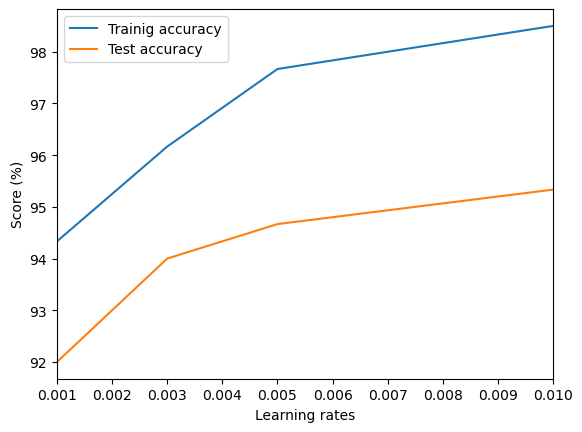

In [15]:
learning_rates = [0.001, 0.003, 0.005, 0.01]
scores_train = []
scores_test = []

for alpha in learning_rates:
    logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=alpha, print_cost=False)        
    scores_train.append(logistic_regression_model['score_train'])
    scores_test.append(logistic_regression_model['score_test'])
    
plt.plot(learning_rates, scores_train, label="Trainig accuracy")
plt.plot(learning_rates, scores_test, label="Test accuracy")
plt.xlim(learning_rates[0], learning_rates[-1])
plt.xlabel('Learning rates')
plt.ylabel('Score (%)')
plt.legend()
plt.show()

According to the graph, of the learning rates taken, the one that gives the best performance is 0.01

# Algorithm (with sklearn)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [17]:
norm = StandardScaler()
X_train = train_set_x_flatten.T
X_train_norm = norm.fit_transform(X_train)

In [18]:
model = LogisticRegression(max_iter=1500)

y_train = train_set_y.reshape(-1)
model.fit(X_train_norm, y_train)

LogisticRegression(max_iter=1500)

In [19]:
X_test = test_set_x_flatten.T
X_test_norm = norm.fit_transform(X_test)
y_test = test_set_y.reshape(-1)

print(f'The model has an accuracy of {model.score(X_train_norm, y_train) * 100}% in training data')
print(f'The model has an accuracy of {(model.score(X_test_norm, y_test) * 100):.2f}% in test data')

The model has an accuracy of 100.0% in training data
The model has an accuracy of 97.33% in test data
